In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_data.csv')

In [3]:
df.head()

,text,sentiment_label,tokens
0,youll thank one day,3,"{'input_ids': [101, 2017, 3363, 4067, 2028, 21..."
1,heh mini snack baggies market little kid think...,3,"{'input_ids': [101, 2002, 2232, 7163, 19782, 4..."
2,love,1,"{'input_ids': [101, 2293, 102], 'token_type_id..."
3,thank guy much reached rape crisis hotline res...,3,"{'input_ids': [101, 4067, 3124, 2172, 2584, 90..."
4,house fire red cross brought u thing like toot...,3,"{'input_ids': [101, 2160, 2543, 2417, 2892, 27..."


In [4]:
print("dataset shape:", df.shape)

dataset shape: (100931, 3)


In [5]:
# Define the mapping
label_map = {
    1: 0,
    2: 1,
    3: 2
}

# Replace the values in the sentiment_label column
df['sentiment_label'] = df['sentiment_label'].replace(label_map)


In [6]:
df.head()

,text,sentiment_label,tokens
0,youll thank one day,2,"{'input_ids': [101, 2017, 3363, 4067, 2028, 21..."
1,heh mini snack baggies market little kid think...,2,"{'input_ids': [101, 2002, 2232, 7163, 19782, 4..."
2,love,0,"{'input_ids': [101, 2293, 102], 'token_type_id..."
3,thank guy much reached rape crisis hotline res...,2,"{'input_ids': [101, 4067, 3124, 2172, 2584, 90..."
4,house fire red cross brought u thing like toot...,2,"{'input_ids': [101, 2160, 2543, 2417, 2892, 27..."


In [7]:
import numpy as np

# Assuming your train data is a DataFrame
has_nan = df.isnull().values.any()

if has_nan:
    print("Train data contains NaN values.")
else:
    print("Train data does not contain NaN values.")

Train data contains NaN values.


In [8]:
df.shape

(100931, 3)

In [9]:
df.dropna(axis=0, inplace=True)


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named df

# Extract a subset of 100 rows from the DataFrame
df_20000 = df.head(20000)


In [11]:
df_20000.shape

(20000, 3)

In [13]:
# Split the subset into train, test, and validation sets
train_df, test_val_df = train_test_split(df_20000, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Verify the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Validation set shape:", val_df.shape)


Train set shape: (14000, 3)
Test set shape: (3000, 3)
Validation set shape: (3000, 3)


In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00


In [15]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU")

CUDA is available


In [16]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

# Step 2: Model Architecture

class SentimentClassifier(nn.Module):
    def __init__(self, pretrained_model_name, hidden_size, num_classes, dropout_rate):
        super(SentimentClassifier, self).__init__()
        self.transformer = DistilBertModel.from_pretrained(pretrained_model_name)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs):
        outputs = self.transformer(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]  # Get the hidden states from the transformer
        _, (hidden, _) = self.lstm(outputs)  # Apply LSTM to the transformer outputs
        hidden = hidden.squeeze(0)  # Squeeze the LSTM hidden state
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)  # Pass the hidden state through a linear layer
        return logits

# Define hyperparameters
pretrained_model_name = 'distilbert-base-uncased'
hidden_size = 768  # DistilBERT uses a hidden size of 768
num_classes = 3  # positive, negative, neutral
dropout_rate = 0.2

# Initialize the model
model = SentimentClassifier(pretrained_model_name, hidden_size, num_classes, dropout_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import f1_score

# Step 1: Data Preparation

# Assuming you already have train_data, val_data, and test_data DataFrames

# Define a tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize and encode the text
def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=512,  # Adjust this value according to your needs
        truncation=True,
        return_tensors='pt'
    )

# Create a custom dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.texts = data['text'].tolist()
        self.labels = data['sentiment_label'].tolist()

    def __len__(self):
            return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded_text = tokenize_text(text)
        sample = {
            'input_ids': encoded_text['input_ids'].squeeze(),
            'attention_mask': encoded_text['attention_mask'].squeeze(),
            'label': label
        }
        return sample

# Create datasets and dataloaders

train_dataset = SentimentDataset(train_df)
val_dataset = SentimentDataset(val_df)
test_dataset = SentimentDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)




In [18]:
model

SentimentClassifier(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

In [19]:
device

device(type='cuda')

In [20]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
import torch.optim as optim
from sklearn.metrics import f1_score

# Step 3: Hyperparameter Tuning
# Define hyperparameters
learning_rate = 0.0001
batch_size = 16
num_epochs = 5

# Create lists to store loss and accuracy values
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        inputs = {'input_ids': batch['input_ids'], 'attention_mask': batch['attention_mask']}
        labels = batch['label']

        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        # Forward pass
        logits = model(inputs)
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
  # Evaluate on the validation set
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch in val_dataloader:  # Iterate over the validation data in batches
            inputs = {'input_ids': batch['input_ids'],'attention_mask': batch['attention_mask']}
            labels = batch['label']

            inputs = {key: value.to(device) for key, value in inputs.items()}
            labels = labels.to(device)


            logits = model(inputs)
            _, predictions = torch.max(logits, dim=1)
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

# Calculate validation metrics
    val_f1_score = f1_score(val_labels, val_predictions, average='weighted')

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}: Loss: {running_loss/len(train_dataloader)}, Val F1-Score: {val_f1_score}")


Epoch 1/5: Loss: 0.4033636321297714, Val F1-Score: 0.8859443882534721
Epoch 2/5: Loss: 0.2049401729239949, Val F1-Score: 0.8947587134433282
Epoch 3/5: Loss: 0.11445843069488183, Val F1-Score: 0.9057909193843998
Epoch 4/5: Loss: 0.08149987924917201, Val F1-Score: 0.8820809024397902
Epoch 5/5: Loss: 0.07761695404560305, Val F1-Score: 0.8950398208619635


In [22]:
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {'input_ids': batch['input_ids'], 'attention_mask': batch['attention_mask']}
        labels = batch['label']

        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        logits = model(inputs)
        _, predictions = torch.max(logits, dim=1)
        test_predictions.extend(predictions.tolist())
        test_labels.extend(labels.tolist())

test_f1_score = f1_score(test_labels, test_predictions, average='weighted')

print(f"Test F1-Score: {test_f1_score}")


Test F1-Score: 0.8850140739617232


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the predicted labels and true labels to numpy arrays
val_predictions = np.array(val_predictions)
val_labels = np.array(val_labels)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)

# Calculate precision, recall, and F1-score
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.901
Precision: 0.8960250514172927
Recall: 0.901
F1-score: 0.8950398208619635


In [35]:
val_labels

array([2, 2, 2, ..., 2, 2, 2])

device(type='cuda')

In [34]:
print(val_loss)

[]


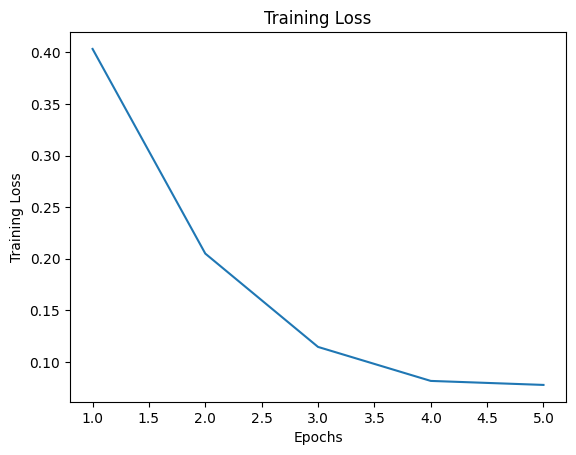

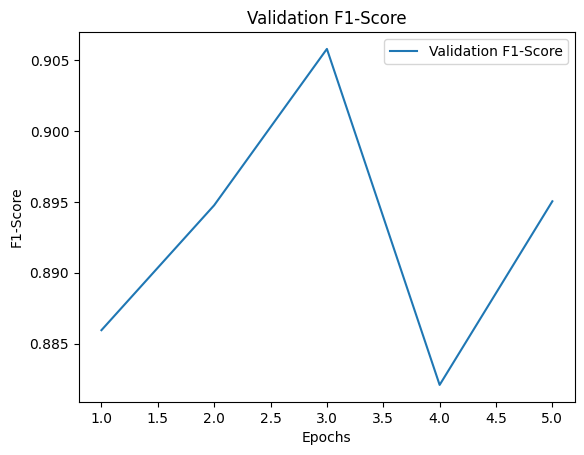

In [32]:
import matplotlib.pyplot as plt

train_loss_values = [0.4033636321297714, 0.2049401729239949, 0.11445843069488183, 0.08149987924917201, 0.07761695404560305]
val_f1_scores = [0.8859443882534721, 0.8947587134433282, 0.9057909193843998, 0.8820809024397902, 0.8950398208619635]

num_epochs = len(train_loss_values)

# Plot the Training Loss curve
plt.plot(range(1, num_epochs+1), train_loss_values)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

# Plot the Training and Validation Accuracy curve
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('Validation F1-Score')
plt.legend()
plt.show()


ValueError: ignored

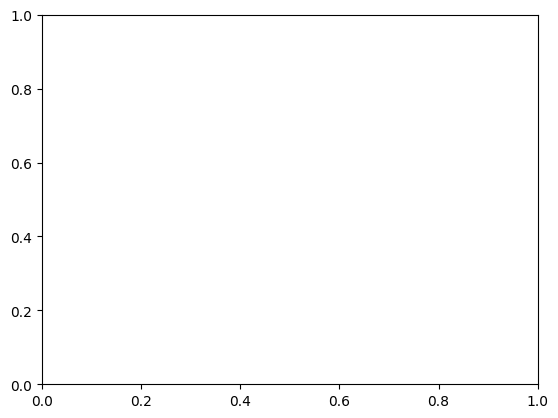

In [38]:
import matplotlib.pyplot as plt

# Plot the Loss curve
plt.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the Accuracy curve
plt.plot(range(1, num_epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
torch.cuda.empty_cache()